In [25]:
%reload_ext autoreload
%autoreload 2

In [26]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [27]:
from fastai import *
from fastai.text import *

# Python code Examples (testing out tokenizer)

## Data

### Reading the texts

In [9]:
PATH = Path('/home/farzin/rnn_python_code/wiki103_from_download')

In [8]:
all_texts_df = pd.read_csv('/home/farzin/fast_ai/fastai_v1/courses/dl2/imdb_scripts/data/wiki/en/train.csv',sep='%$#')

/home/farzin/anaconda3/envs/fastaiv1_dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [12]:
all_texts = all_texts_df.values.squeeze()

In [13]:
#all_texts = np.concatenate([train_texts,valid_texts])
idx = np.random.permutation(len(all_texts))
cut = int(0.1 * len(idx))
train_df = pd.DataFrame({'text':all_texts[idx[cut:]], 'labels':[0] * (len(all_texts)-cut)}, columns=['labels','text'])
valid_df = pd.DataFrame({'text':all_texts[idx[:cut]], 'labels':[0] * cut}, columns=['labels','text'])

In [14]:
## Does any of this apply to Python code?  What do I need to include here that is relevant?

#export
def sub_br(t:str) -> str:
    "Replaces the <br /> by \n"
    re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
    return re_br.sub("\n", t)

def spec_add_spaces(t:str) -> str:
    "Add spaces between special characters"
    return re.sub(r'([/#])', r' \1 ', t)

def rm_useless_spaces(t:str) -> str:
    "Remove multiple spaces"
    return re.sub(' {2,}', ' ', t)

def replace_rep(t:str) -> str:
    "Replace repetitions at the character level"
    def _replace_rep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_REP} {len(cc)+1} {c} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)
    
def replace_wrep(t:str) -> str:
    "Replace word repetitions"
    def _replace_wrep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_WREP} {len(cc.split())+1} {c} '
    re_wrep = re.compile(r'(\b\w+\W+)(\1{3,})')
    return re_wrep.sub(_replace_wrep, t)

def deal_caps(t:str) -> str:
    "Replace words in all caps"
    res = []
    for s in re.findall(r'\w+|\W+', t):
        res += ([f' {TK_UP} ',s.lower()] if (s.isupper() and (len(s)>2)) else [s.lower()])
    return ''.join(res)

def fixup(x:str) -> str:
    "List of replacements from html strings"
    re1 = re.compile(r'  +')
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>',UNK).replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

default_rules = [fixup, replace_rep, replace_wrep, deal_caps, spec_add_spaces, rm_useless_spaces, sub_br]
default_spec_tok = [BOS, FLD, UNK, PAD]

In [15]:
tokenizer = Tokenizer(pre_rules=default_rules, special_cases=[BOS, FLD, 'xxunk', 'xxpad'], n_cpus=4)

In [16]:
tokenizer

Tokenizer SpacyTokenizer in en with the following rules:
 - fixup
 - replace_rep
 - replace_wrep
 - deal_caps
 - spec_add_spaces
 - rm_useless_spaces
 - sub_br
 - replace_all_caps
 - deal_caps

In [17]:
train_df = train_df.dropna()
valid_df = valid_df.dropna()

In [18]:
max_vocab = 60000 #can we make this the full possible vocab at 260k?
batch_size = 32

keyword_args = {'max_vocab':max_vocab,'bs':batch_size}
data = TextLMDataBunch.from_df(PATH, train_df, valid_df, tokenizer=tokenizer,
                               text_cols='text', label_cols='labels',**keyword_args)

In [35]:
BOS

'xxbos'

In [48]:
train_df.iloc[0,1]

"As a result of Pattiz's efforts, the Bush administration requested funding for the channel from Congress, and obtained $62 million in funding for its first year of operation (including start-up costs). In the fall of 2003, construction began to renovate an old TV channel building in Springfield, VA into a modern broadcast facility for the new channel. Construction was completed less than six months later, and Alhurra's first broadcast aired 14 February 2004."

In [73]:
np.concatenate( (data.train_ds.x[0].data[:1], data.train_ds.x[0].data[1:][::-1]) )

array([  2,  10, 388, 229, ...,  12, 527,  16,  22])

In [79]:
data.train_ds.x[0].data

array([  2,  22,  16, 527, ..., 481, 229, 388,  10])

In [78]:
data.train_ds.x[0].data = np.concatenate( (data.train_ds.x[0].data[:1], data.train_ds.x[0].data[1:][::-1]) )

In [19]:
len(data.vocab.itos)

60004

In [20]:
data.save()

In [21]:
!ls -lhart {PATH}/tmp/

total 1.2G
drwxrwxr-x 3 farzin farzin 4.0K Jan 17 13:23 ..
-rw-rw-r-- 1 farzin farzin 999K Jan 17 13:23 itos.pkl
-rw-rw-r-- 1 farzin farzin 1.1G Jan 17 13:23 train_ids.npy
-rw-rw-r-- 1 farzin farzin  20M Jan 17 13:23 train_lbl.npy
-rw-rw-r-- 1 farzin farzin 118M Jan 17 13:24 valid_ids.npy
-rw-rw-r-- 1 farzin farzin 2.2M Jan 17 13:24 valid_lbl.npy
-rw-rw-r-- 1 farzin farzin    2 Jan 17 13:24 classes.txt
drwxrwxr-x 2 farzin farzin 4.0K Jan 17 13:24 .


In [29]:
bptt = 140
emb_sz,nh,nl = 400,1111,4

learn = language_model_learner(data,bptt,emb_sz,nh,nl,drop_mult=0.5,qrnn=True)
learn.unfreeze()
learn.model

SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(60004, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60004, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=800, out_features=3333, bias=True)
        )
      )
      (1): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1111, out_features=3333, bias=True)
        )
      )
      (2): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1111, out_features=3333, bias=True)
        )
      )
      (3): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1111, out_features=1200, bias=True)
        )
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
      (3): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Li

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


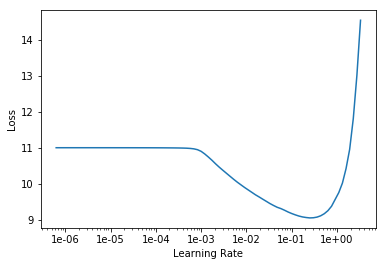

In [23]:
lr_find(learn)
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(20, 1e-2, moms=(0.8,0.7), wd=0.03, pct_start=0.25)

epoch,train_loss,valid_loss,accuracy
1,4.556215,4.435592,0.305401
2,4.568444,4.433817,0.302561
3,4.663723,4.550586,0.292597
4,4.731622,4.635006,0.284766
5,4.789747,4.663291,0.282145
6,4.782752,4.651239,0.283699
7,4.756957,4.639008,0.284986
8,4.752146,4.618721,0.286460
9,4.718633,4.594611,0.288452
10,4.657288,4.555625,0.291437


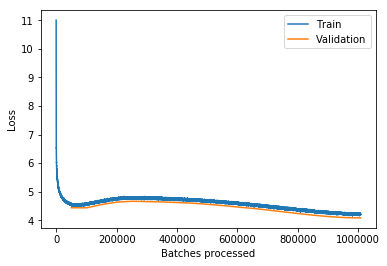

In [31]:
learn.recorder.plot_losses()

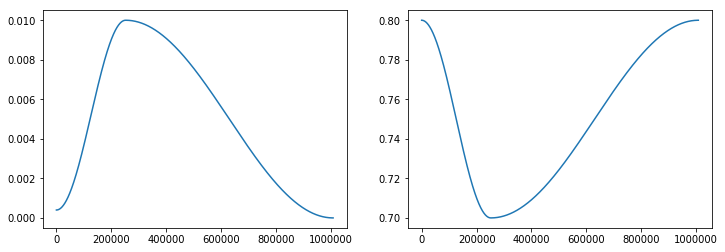

In [32]:
learn.recorder.plot_lr(show_moms=True)

In [33]:
np.exp(4.08)

59.14546984988227

In [81]:
learn.fit_one_cycle(4, 1e-2/4, moms=(0.95,0.8), wd=0.03, pct_start=0.15)

epoch,train_loss,valid_loss,accuracy
1,4.408109,4.277699,0.316112
2,4.365920,4.211289,0.322720
3,4.263391,4.117272,0.333146
4,4.188361,4.072366,0.338838


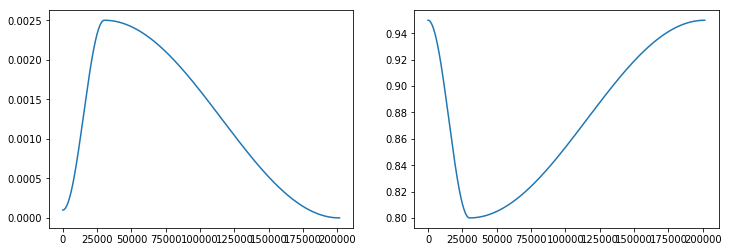

In [84]:
learn.recorder.plot_lr(show_moms=True)

In [92]:
learn.fit(1,0.00025,wd=0.03)

epoch,train_loss,valid_loss,accuracy
1,4.239735,4.084991,0.337239


In [93]:
## data from Jan 17 got overwrittent with BWD data.  re-save after training
data.save()

In [88]:
learn.opt.mom

0.95

In [90]:
learn.save("wiki103_raw_articles_spacy_20190123")

In [91]:
learn.save_encoder('wiki103_spacy_enc')

In [20]:
ss="""#!/usr/bin/python\nimport unittest\n\n"""

output = learn.predict(ss, 20,no_unk=False,temperature=5.,min_p=1/500.)
print(output)

Total time: 00:03

#!/usr/bin/python
import unittest

 def xxunk ) 
  xxunk , xxunk ) 
  xxunk ) 
  xxunk ) : 
  xxunk ) 
  xxunk


In [21]:
print(tokenizer._process_all_1([ss])[0])

[' ', '#', '!', '/', 'usr', '/', 'bin', '/', 'python', '\n', 'import', 'unittest', '\n\n']


In [79]:
## sample string -> tokenize -> itos and back again!
#ss="""import numpy as np\nimport matplotlib.pyplot as plt\n\n\n\n    """
#ss='''\"\"\"'''
ss="""#!/usr/bin/python\nimport """
#ss="""#!/usr/bin/python\nimport requests\nimport six\nimport matplotlib.pyplot as plt\n\n """
#ss="""def somefunct(x,y):\n"""
#ss="""#!/usr/bin/python\nimport pandas as pd\nimport numpy as np\n\n"""
ss_toks = tokenizer._process_all_1([ss])[0]
print(ss_toks)

[' ', '#', '!', '/', 'usr', '/', 'bin', '/', 'python', '\n', 'import']


In [80]:
txt_as_ints = data.train_ds.vocab.numericalize(ss_toks)
print(txt_as_ints)
t = data.train_ds.vocab.textify(txt_as_ints)

[0, 11, 54, 23, 156, 23, 159, 23, 86, 9, 30]


In [81]:
tensor(txt_as_ints).unsqueeze(dim=1).cuda()

tensor([[  0],
        [ 11],
        [ 54],
        [ 23],
        [156],
        [ 23],
        [159],
        [ 23],
        [ 86],
        [  9],
        [ 30]], device='cuda:0')

In [82]:
m = learn.model
m[0].bs=1
m.eval()
m.reset()
res,*_=m(tensor(txt_as_ints).unsqueeze(dim=1).cuda())

In [83]:
res[-1][:30]

tensor([ 9.4795, -7.9827, -2.1570,  2.0627, -0.4379, -2.0274,  0.4841, -0.8407,
        -1.7358, -1.4621, -1.9805,  5.8239, -5.2976,  2.9844,  3.1824, -2.9699,
        -5.3718,  4.6217, -1.0198, -3.7078, -4.6312, -1.1749,  2.0002,  2.4551,
        -6.0976,  0.3126, -4.0764, -7.3002, -0.6942,  0.5444], device='cuda:0',
       grad_fn=<SliceBackward>)

In [84]:
data.train_ds.vocab.itos[30]

'import'

In [85]:
print(res[-1].topk(2)[1][0].data)
data.train_ds.vocab.itos[res[-1].topk(2)[1][0]]

tensor(0, device='cuda:0')


'xxunk'

In [88]:
print(ss,"\n")

rest_of_output = []
for i in range(800):
    n=res[-1].topk(2)[1]
#    import pdb;pdb.set_trace()
    n = n[1] if n[0]==0 else n[0] #if xxunk, pick the next best...
    #print(itos_wt[n])
    rest_of_output.append(data.train_ds.vocab.itos[n])
#    print(TEXT.vocab.itos[n.data[0]], end=' ')
#    res,*_ = m(n[0].unsqueeze(0).unsqueeze(0)) #m(n[0].unsqueeze(0))
    res,*_ = m(n.unsqueeze(dim=0).unsqueeze(dim=1))
    
    if rest_of_output[-3:] == ['xxbos', 'xxfld', '1']:
        ## end of file signal from generator
        break
print(' '.join(rest_of_output)) ## better way to re-build the data? .join seems to add spaces where there are none

## sometimes we get into "loop" where we keep returning the same data?  How to break that?

#!/usr/bin/python
import  

# ! / usr / bin / env python3 
  # -*- coding : utf-8 -*- 

 from multiprocessing import process , queue 
 import os , time , random 

  # get : 

 with open('test.txt ' , ' w ' ) as f : 
  s = f.read ( ) 
  print('status : ' , f.status , f.reason ) 
  for k , v in f.getheaders ( ) : 
  print('%s : % s ' % ( k , v ) ) 
  print('data : ' , v ) 

  # iter : 
 print('iter % d ' % ( k , os.getpid ( ) ) ) 

 print ( ) 
 xxbos xxfld 1


In [41]:
' '.join(rest_of_output)

"# ! / usr / bin / env python3 \n  # -*- coding : utf-8 -*- \n\n from multiprocessing import process , queue \n import os , time , random \n\n  # get : \n\n with open('test.txt ' , ' w ' ) as f : \n  s = f.read ( ) \n  print('status : ' , f.status , f.reason ) \n  for k , v in f.getheaders ( ) : \n  print('%s : % s ' % ( k , v ) ) \n  print('data : ' , v ) \n\n  # iter : \n print('iter % d ' % ( k , os.getpid ( ) ) ) \n\n print ( ) \n xxbos xxfld 1"

In [42]:
compile(' '.join(rest_of_output),'first_test','exec')

IndentationError: unexpected indent (first_test, line 4)